In [2]:
import pandas as pd
import sys
sys.path.insert(0, "../..")
from utils.simulation import BacktestSimulation, TradingAction
from utils.black_scholes import black_scholes_call
from datetime import datetime, timedelta

ticker = "MSTR"
strike_factor = 1.2
interest_rate = 0.05
time = 30 / 365

Loading market data...


/Users/ryan/Desktop/quantitative-trading-models/strategies/covered_call/../../utils/simulation.py:229: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


Running simulation from 2023-01-03 to 2024-12-30
Total trading days: 501
Performance Stats

=== Performance Summary ===
Initial Value: $10,000.00
Final Value: $66,659.66
Total Return: 566.60%
Sharpe Ratio: 1.67
Max Drawdown: 34.27%
Annualized Volatility: 72.02%

Total transactions: 84

Transaction History:
         date          action ticker  shares       price         total  contracts      strike  premium_per_share  total_premium expiration  current_price  shares_sold
0  2023-01-03       BUY_STOCK   MSTR   689.0   14.502000   9991.877900        NaN         NaN                NaN            NaN        NaT            NaN          NaN
1  2023-01-03       SELL_CALL   MSTR     NaN         NaN           NaN        6.0   17.402400           0.358609     215.165155 2023-02-02            NaN          NaN
2  2023-01-04       BUY_STOCK   MSTR    13.0   16.506001    214.578007        NaN         NaN                NaN            NaN        NaT            NaN          NaN
3  2023-02-02  CALL_EXER

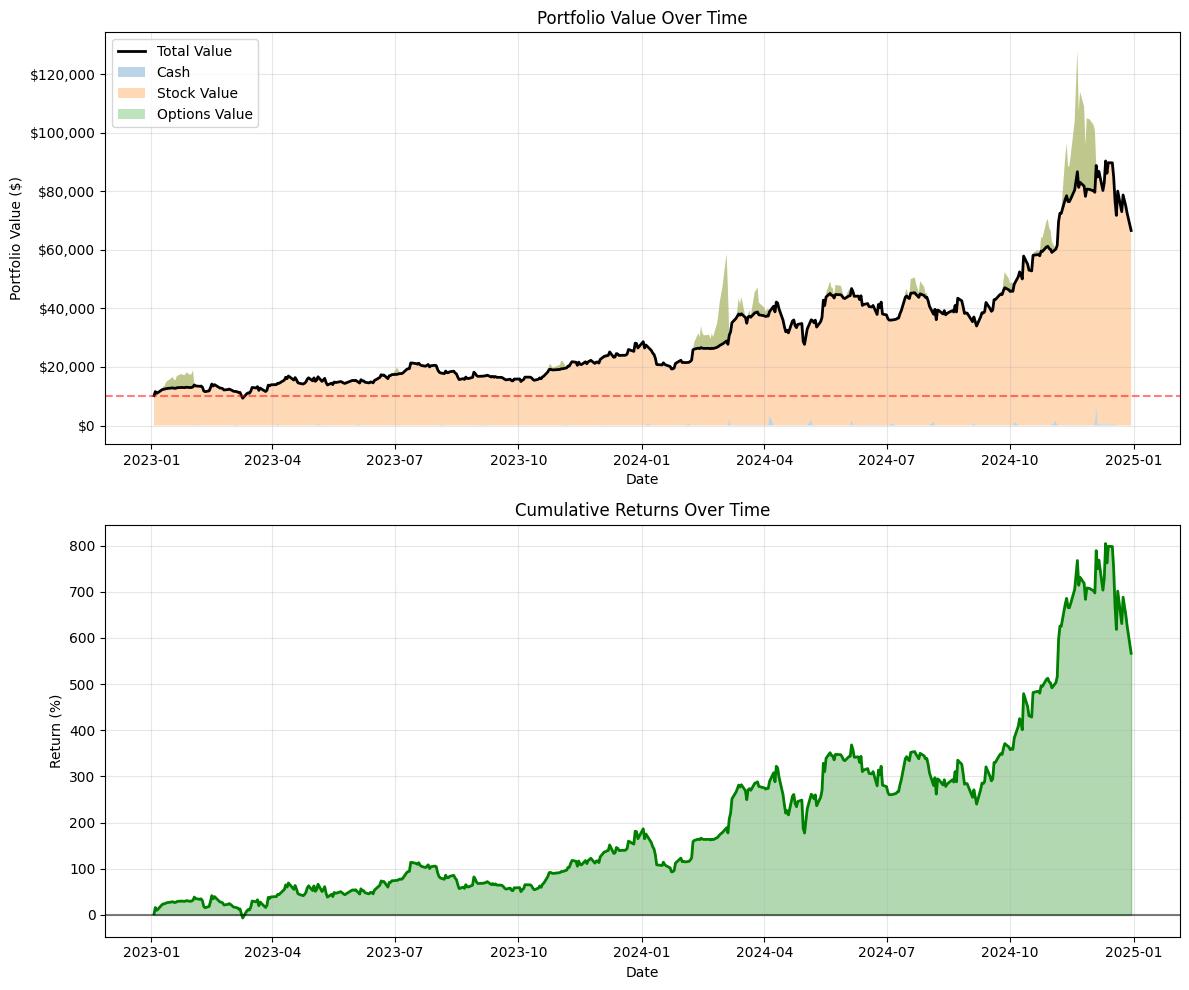

In [3]:
def covered_call_strategy(date, portfolio, market_data, actions):
    current_price = market_data['prices'][ticker]
    
    max_shares = int(portfolio.cash / current_price)
    if max_shares > 0:
        actions.buy_stock(portfolio, ticker, max_shares, current_price)
    
    if ticker in portfolio.positions and portfolio.positions[ticker].shares > 0:
        has_active_call = any(opt.ticker == ticker and opt.option_type == 'call' 
                              for opt in portfolio.options)
        
        if not has_active_call:
            shares = portfolio.positions[ticker].shares
            contracts = shares // 100
            
            if contracts > 0:
                strike = current_price * strike_factor
                expiration = date + timedelta(days=30)
                
                if ticker in market_data['volatility']:
                    vol_data = market_data['volatility'][ticker]
                    if len(vol_data) > 0:
                        vol = vol_data.iloc[-1, 0] if hasattr(vol_data.iloc[-1], '__iter__') else vol_data.iloc[-1]
                        
                        if not pd.isna(vol):
                            premium = black_scholes_call(
                                S=current_price,
                                K=strike,
                                sigma=vol,
                                r=interest_rate,
                                t=time
                            )
                            
                            actions.sell_call(
                                portfolio=portfolio,
                                ticker=ticker,
                                strike=strike,
                                expiration=expiration,
                                contracts=contracts,
                                premium=premium
                            )

sim = BacktestSimulation(
    tickers=["MSTR"],
    start_date=datetime(2023, 1, 1),
    end_date=datetime(2024, 12, 31),
    initial_cash=10000,
    strategy_callback=covered_call_strategy
)

sim.run()

print("Performance Stats")
sim.print_performance_stats()

transactions = sim.get_transactions()
print(f"\nTotal transactions: {len(transactions)}")
print("\nTransaction History:")
print(transactions.to_string())
sim.plot_portfolio_history()

Loading market data...
Running simulation from 2023-01-03 to 2024-12-30
Total trading days: 501
Performance Stats

=== Performance Summary ===
Initial Value: $10,000.00
Final Value: $208,747.56
Total Return: 1987.48%
Sharpe Ratio: 2.10
Max Drawdown: 46.42%
Annualized Volatility: 93.59%

Total transactions: 1

Transaction History:
        date     action ticker  shares   price      total
0 2023-01-03  BUY_STOCK   MSTR     689  14.502  9991.8779


/Users/ryan/Desktop/quantitative-trading-models/strategies/covered_call/../../utils/simulation.py:229: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


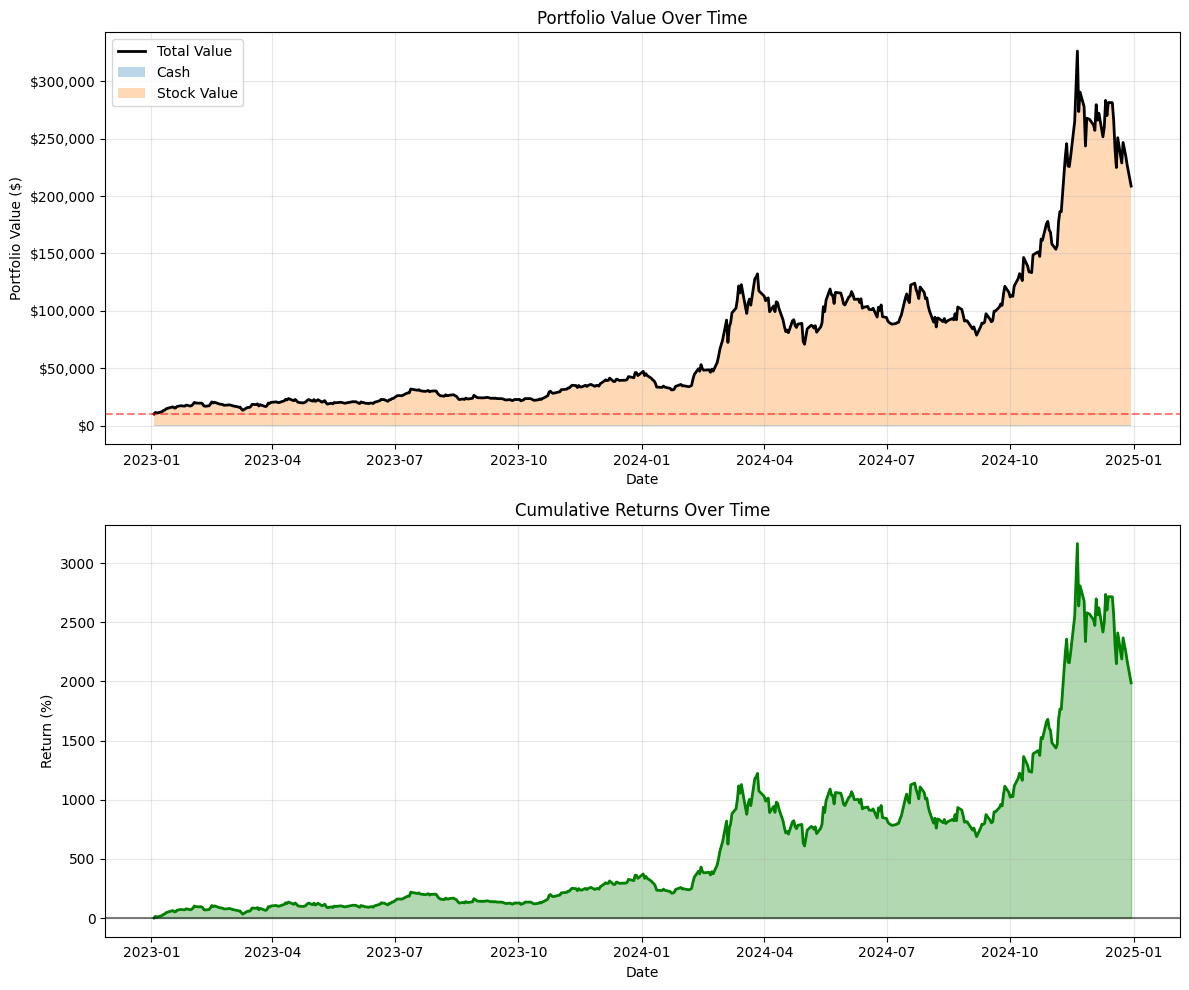

In [4]:
def buy_and_hold(date, portfolio, market_data, actions):
    current_price = market_data['prices'][ticker]

    max_shares = int(portfolio.cash / current_price)
    if max_shares > 0:
        actions.buy_stock(portfolio, ticker, max_shares, current_price)


sim = BacktestSimulation(
    tickers=["MSTR"], 
    start_date=datetime(2023, 1, 1), 
    end_date=datetime(2024, 12, 31),
    initial_cash=10000,
    strategy_callback=buy_and_hold)

sim.run()

print("Performance Stats")
sim.print_performance_stats()

transactions = sim.get_transactions()
print(f"\nTotal transactions: {len(transactions)}")
print("\nTransaction History:")
print(transactions.to_string())
sim.plot_portfolio_history()